In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-03-BIGDATA/master/init.py
import init; init.init(force_download=False);
from IPython.display import Image

replicating local resources


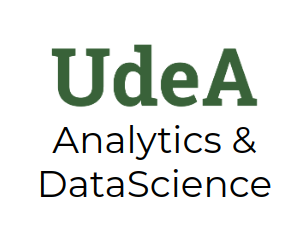

In [2]:
Image("local/imgs/udea-datascience.png")

Inicialmente se procede a realizar la configuración del entorno de trabajo

In [3]:
#Instalación
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install -q findspark

#Variables de Entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

#SparkContext
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [4]:
# Contexto SQL
from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)

In [5]:
# Librerias
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType
import pyspark.sql.functions as F
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import QuantileDiscretizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# **TALLER 3: Machine Learning**
## Desarrollado por: Mg. Efraín Alberto Oviedo
## Universidad de Antioquia

Por favor, ingrese la información de cada integrante del grupo de trabajo

**Nombre Completo:**

**Cédula:**

**Correo Institucional:**

#**Análisis de pacientes de hospital de Envigado**

El archivo poblacion_atendida.csv contiene información sobre los pacientes atendidos en un Hospital en Envigado. Para cada paciente se tiene la siguiente información:

* SEXO
* ESTADO_CIVIL
* ZONA_RES
* MUN_RES
* PAIS_NCTO
* EDAD
* ESCOLARIDAD_PACIENTE

Fuente de los datos: https://www.datos.gov.co/Salud-y-Protecci-n-Social/Poblaci-n-Atendida-a-o-2020/4ike-xz34


Se solicita de su ayuda para realizar las siguientes actividades:

In [6]:
# Carga de los datos
pobAtendidaDF = spark.read.csv('local/data/poblacion_atendida.csv',
                                sep = ';',
                                header = True,
                                inferSchema = True)

##**A) Preparación de datos**

Revise cada una de las variables disponibles y realice la respectiva prepración de datos antes de proceder a crear los modelos de Machine Learning


### **1. Identificación de variables**

En esta etapa se realizó lo siguiente:
* Propiedades del conjunto de datos
* Tipos de datos (verificar carga correcta de datos)
* Inspección rapida del dataset
* Información resumen del dataset

#### **1.1. Propiedades del conjunto de datos**

In [7]:
pobAtendidaDF = pobAtendidaDF.cache()
pobAtendidaDF.is_cached

True

In [8]:
# Cantidad de registros
print(f"Numero de filas: {pobAtendidaDF.count()}")
columnas = pobAtendidaDF.columns
print(f"Numero de columnas: {len(columnas)}")

Numero de filas: 55962
Numero de columnas: 8


In [9]:
# Columnas
columnas

['ID_UNICO',
 'SEXO',
 'ESTADO_CIVIL',
 'ZONA_RES',
 'MUN_RES',
 'PAIS_NCTO',
 'EDAD',
 'ESCOLARIDAD_PACIENTE']

#### **1.2. Tipos de datos**

In [10]:
# Tipos de datos de las columnas
pobAtendidaDF.dtypes

[('ID_UNICO', 'int'),
 ('SEXO', 'string'),
 ('ESTADO_CIVIL', 'string'),
 ('ZONA_RES', 'string'),
 ('MUN_RES', 'string'),
 ('PAIS_NCTO', 'string'),
 ('EDAD', 'int'),
 ('ESCOLARIDAD_PACIENTE', 'string')]

In [11]:
# Esquema
pobAtendidaDF.printSchema()

root
 |-- ID_UNICO: integer (nullable = true)
 |-- SEXO: string (nullable = true)
 |-- ESTADO_CIVIL: string (nullable = true)
 |-- ZONA_RES: string (nullable = true)
 |-- MUN_RES: string (nullable = true)
 |-- PAIS_NCTO: string (nullable = true)
 |-- EDAD: integer (nullable = true)
 |-- ESCOLARIDAD_PACIENTE: string (nullable = true)



In [12]:
# Se almacena para usar luego
pobAtendidaDF_original_schema = pobAtendidaDF.schema

In [13]:
pobAtendidaDF_cod = pobAtendidaDF
pobAtendidaDF_cod.cache()

DataFrame[ID_UNICO: int, SEXO: string, ESTADO_CIVIL: string, ZONA_RES: string, MUN_RES: string, PAIS_NCTO: string, EDAD: int, ESCOLARIDAD_PACIENTE: string]

#### **1.3. Inspección del dataset**



In [14]:
pobAtendidaDF.show(10)

+--------+---------+---------------+--------+---------------+---------+----+--------------------+
|ID_UNICO|     SEXO|   ESTADO_CIVIL|ZONA_RES|        MUN_RES|PAIS_NCTO|EDAD|ESCOLARIDAD_PACIENTE|
+--------+---------+---------------+--------+---------------+---------+----+--------------------+
|  676901|MASCULINO|     SOLTERO(A)|  URBANA|  ZONA BANANERA| COLOMBIA|  54|   BASICA SECUNDARIA|
|  676949|MASCULINO|    UNION LIBRE|  URBANA|       MEDELLIN| COLOMBIA|  27|     SIN INFORMACION|
|  676948|MASCULINO|SIN INFORMACION|  URBANA|SIN INFORMACION| COLOMBIA|   0|     SIN INFORMACION|
|  635991| FEMENINO|SIN INFORMACION|  URBANA|         ITAGUI| COLOMBIA|   0|     SIN INFORMACION|
|  676947| FEMENINO|     SOLTERO(A)|  URBANA|         ITAGUI| COLOMBIA|  24|   BASICA SECUNDARIA|
|  676946|MASCULINO|SIN INFORMACION|  URBANA|         ITAGUI| COLOMBIA|   0|     SIN INFORMACION|
|  666994|MASCULINO|    UNION LIBRE|  URBANA|       ENVIGADO| COLOMBIA|  37|         TECNOLOGICA|
|  676812|MASCULINO|

#### **1.4. Información resumen del data frame**

In [15]:
# Resumen del data frame
print(f"{'#':<3} {'Columna':<22} {'Cant. de no-nulos'}   tipo")
print(f"{54*'-'}")
i = 1
for c in columnas:
  print(f"{i:<3d} {c:<22} {pobAtendidaDF.select(c).where(~F.col(c).isNull()).count():<8d} non-null   {pobAtendidaDF.select(c).dtypes[0][1]}")
  i+=1

#   Columna                Cant. de no-nulos   tipo
------------------------------------------------------
1   ID_UNICO               55962    non-null   int
2   SEXO                   55962    non-null   string
3   ESTADO_CIVIL           55962    non-null   string
4   ZONA_RES               55962    non-null   string
5   MUN_RES                55962    non-null   string
6   PAIS_NCTO              55962    non-null   string
7   EDAD                   55962    non-null   int
8   ESCOLARIDAD_PACIENTE   55962    non-null   string


Vemos que el dataframe no tiene datos nulos y los tipos de datos de cada columna coinciden con lo que se espera.

### **2. Tratamiendo de duplicados**

Se resume en:
* Eliminar variables duplicadas (columnas)
* Eliminar registros duplicados (filas)
* Eliminar variables irrelevantes (ID, cedula, nombre, teléfono)

#### **2.1. Eliminación de variables irrelevantes**

Vamos a eliminar unicamente la columnas `ID_UNICO`.

In [16]:
var_irrelvantes = ['ID_UNICO']
pobAtendidaDF = pobAtendidaDF.drop(*var_irrelvantes)

In [17]:
# Inspeccion del resultado
pobAtendidaDF.show(10)

+---------+---------------+--------+---------------+---------+----+--------------------+
|     SEXO|   ESTADO_CIVIL|ZONA_RES|        MUN_RES|PAIS_NCTO|EDAD|ESCOLARIDAD_PACIENTE|
+---------+---------------+--------+---------------+---------+----+--------------------+
|MASCULINO|     SOLTERO(A)|  URBANA|  ZONA BANANERA| COLOMBIA|  54|   BASICA SECUNDARIA|
|MASCULINO|    UNION LIBRE|  URBANA|       MEDELLIN| COLOMBIA|  27|     SIN INFORMACION|
|MASCULINO|SIN INFORMACION|  URBANA|SIN INFORMACION| COLOMBIA|   0|     SIN INFORMACION|
| FEMENINO|SIN INFORMACION|  URBANA|         ITAGUI| COLOMBIA|   0|     SIN INFORMACION|
| FEMENINO|     SOLTERO(A)|  URBANA|         ITAGUI| COLOMBIA|  24|   BASICA SECUNDARIA|
|MASCULINO|SIN INFORMACION|  URBANA|         ITAGUI| COLOMBIA|   0|     SIN INFORMACION|
|MASCULINO|    UNION LIBRE|  URBANA|       ENVIGADO| COLOMBIA|  37|         TECNOLOGICA|
|MASCULINO|     SOLTERO(A)|  URBANA|       MEDELLIN| COLOMBIA|  35|     BASICA PRIMARIA|
|MASCULINO|SIN INFORM

In [18]:
# Se actualizan la columnas del dataframe
columnas = pobAtendidaDF.columns

### **3. Analisis univariado**

Este tipo de analisis realiza para:
* **Variables numéricas**: estadística descriptiva, histogramas, box plot.
* **Variables categóricas**: tabla de frecuencias y diagrama de barras.

#### **3.1. Variables númericas**

##### **Estadistica descriptiva**

La unica variable númerica que nos interesa es la `EDAD`

In [19]:
pobAtendidaDF.select('EDAD').describe().show()

+-------+------------------+
|summary|              EDAD|
+-------+------------------+
|  count|             55962|
|   mean|41.761248704478035|
| stddev|23.162071761943924|
|    min|                 0|
|    max|               109|
+-------+------------------+



##### **Histograma**

A continuación se muestra el histograma para la variable numerica empleando 20 particiones.

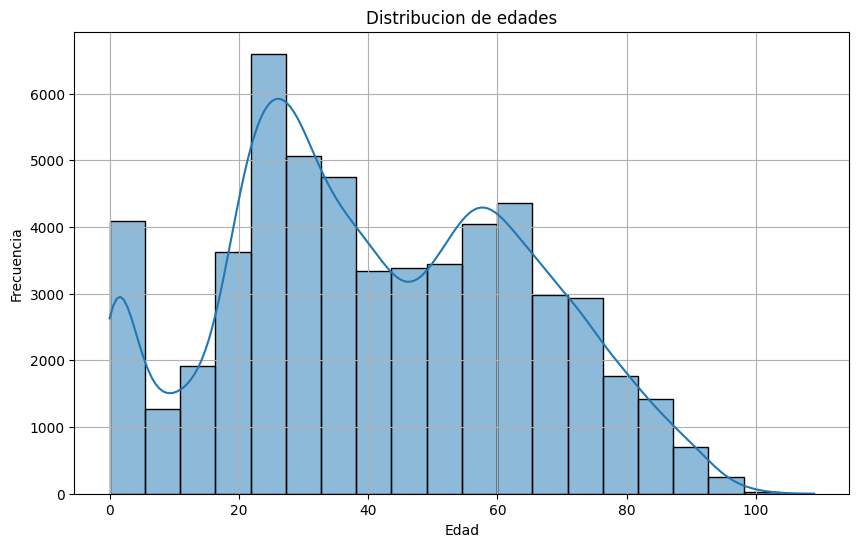

In [20]:
df_pobAtendidaEdad_pandas = pobAtendidaDF.select('EDAD').toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(df_pobAtendidaEdad_pandas, x='EDAD', bins = 20, kde=True)
plt.title('Distribucion de edades')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

#### **3.2. Variables categoricas**

Variables categóricas: tabla de frecuencias y diagrama de barras

##### **Valores unicos por columna**

In [21]:
print(f"{'COLUMNA':>20} [CANT ]: ITEMS")
print(f"{50*'-'}")
for c in columnas:
  if c != 'EDAD':
    items = pobAtendidaDF.select(c).distinct().collect()
    items = [fila[0] for fila in items]
    print(f"{c:>20} [{len(items):>5}]: {', '.join(items)}")


             COLUMNA [CANT ]: ITEMS
--------------------------------------------------
                SEXO [    2]: FEMENINO, MASCULINO
        ESTADO_CIVIL [    6]: SIN INFORMACION, SOLTERO(A), VIUDO(A), SEPARADO(A), UNION LIBRE, CASADO(A)
            ZONA_RES [    2]: RURAL, URBANA
             MUN_RES [  186]: ARMENIA, SAN PABLO, YOLOMBO, NORCASIA, ATACO, ZONA BANANERA, COPACABANA, NUEVA GRANADA, SANTA HELENA  A  Y T, SABANAS DE SAN ANGEL, EL TAMBO, SAN LORENZO, HELICONIA, CASABIANCA, PUERTO ESCONDIDO, LA CRUZ, LA ESPERANZA, LA FLORIDA, TAMESIS, SANTA BARBARA, RETIRO, ANDES, JERSEY, BAGADO, ANDALUCIA, SAN MARCOS, SANTA MARIA, ALBANIA, SAMOA ESTADOUNIDENSE, MEDIO BAUDO, SAN JOSE DEL FRAGUA, ITUANGO, SURATA, FLORENCIA, TARQUI, CONTRATACION, BETULIA, LA PINTADA, OPORAPA, BARRANCAS, SANTA ROSA DE OSOS, ACANDI, TOLEDO, SAN MATEO, SIN INFORMACION, CONCORDIA, EL BANCO, RIOSUCIO, AMALFI, LA SIERRA, VILLANUEVA, CARMEN DEL DARIEN, BOCHALEMA, EL DORADO, SOLANO, SOMALIA, EL LITORAL DEL SAN JUA

##### **Conteo de frecuencias**

In [22]:
for c in columnas:
  if c != 'EDAD':
    print(f"{50*'-'}")
    print(f"{c.center(50)}")
    print()
    pobAtendidaDF.groupBy(c).count().show(pobAtendidaDF.select(c).distinct().count())

--------------------------------------------------
                       SEXO                       

+---------+-----+
|     SEXO|count|
+---------+-----+
| FEMENINO|33168|
|MASCULINO|22794|
+---------+-----+

--------------------------------------------------
                   ESTADO_CIVIL                   

+---------------+-----+
|   ESTADO_CIVIL|count|
+---------------+-----+
|SIN INFORMACION| 8992|
|     SOLTERO(A)|21306|
|       VIUDO(A)| 3001|
|    SEPARADO(A)| 2167|
|    UNION LIBRE| 7526|
|      CASADO(A)|12970|
+---------------+-----+

--------------------------------------------------
                     ZONA_RES                     

+--------+-----+
|ZONA_RES|count|
+--------+-----+
|   RURAL|  297|
|  URBANA|55665|
+--------+-----+

--------------------------------------------------
                     MUN_RES                      

+--------------------+-----+
|             MUN_RES|count|
+--------------------+-----+
|             ARMENIA|    2|
|           SAN PAB

### **4. Analisis bivariado**

#### **4.1. Correlacion**

Para la correlación tener en cuenta las siguientes recomendaciones:
* Correlaciones entre las variables predictoras deben ser menores a 0.7
* Correlaciones con la variable objetivo debe ser mayor a 0.3

<!--
```py
from pyspark.sql.types import *

for c in columnas[1:]:
  if c != 'EDAD':
    # Columna
    listaCol = pobAtendidaNum.select(c).distinct()
    listaCol = [fila[0] for fila in listaCol.collect()]
    # Cast por columna
    for col in listaCol:
      pobAtendidaNum = pobAtendidaNum.withColumn(col, (pobAtendidaNum[c] == col).cast(IntegerType()))
    print(listaCol)
```
-->

Convirtiendo las variables categoricas a numericas:

In [23]:
pobAtendidaNum = pobAtendidaDF
pobAtendidaDF.unpersist()
print(pobAtendidaDF.is_cached)
pobAtendidaNum.cache()
print(pobAtendidaNum.is_cached)

False
True


Ahora vamos a asociar los valores categoricos a datos numericos mediante la función `StringIndexer`.

In [24]:
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer

for c in columnas:
  if c != 'EDAD':
    # Columna
    indexer = StringIndexer(inputCol = c, outputCol = c + '_NUM')
    # Asignacion de valores de indices los strings
    indexer = indexer.fit(pobAtendidaNum)
    # Creacion de columna con valores de indices
    pobAtendidaNum = indexer.transform(pobAtendidaNum)

In [25]:
# Inspeccion de las columnas con las que queda el dataframe
print(f"Columnas: {pobAtendidaNum.columns}")

Columnas: ['SEXO', 'ESTADO_CIVIL', 'ZONA_RES', 'MUN_RES', 'PAIS_NCTO', 'EDAD', 'ESCOLARIDAD_PACIENTE', 'SEXO_NUM', 'ESTADO_CIVIL_NUM', 'ZONA_RES_NUM', 'MUN_RES_NUM', 'PAIS_NCTO_NUM', 'ESCOLARIDAD_PACIENTE_NUM']


In [26]:
# Inspeccion del dataframe
pobAtendidaNum.show(10)

+---------+---------------+--------+---------------+---------+----+--------------------+--------+----------------+------------+-----------+-------------+------------------------+
|     SEXO|   ESTADO_CIVIL|ZONA_RES|        MUN_RES|PAIS_NCTO|EDAD|ESCOLARIDAD_PACIENTE|SEXO_NUM|ESTADO_CIVIL_NUM|ZONA_RES_NUM|MUN_RES_NUM|PAIS_NCTO_NUM|ESCOLARIDAD_PACIENTE_NUM|
+---------+---------------+--------+---------------+---------+----+--------------------+--------+----------------+------------+-----------+-------------+------------------------+
|MASCULINO|     SOLTERO(A)|  URBANA|  ZONA BANANERA| COLOMBIA|  54|   BASICA SECUNDARIA|     1.0|             0.0|         0.0|       14.0|          0.0|                     0.0|
|MASCULINO|    UNION LIBRE|  URBANA|       MEDELLIN| COLOMBIA|  27|     SIN INFORMACION|     1.0|             3.0|         0.0|        1.0|          0.0|                     2.0|
|MASCULINO|SIN INFORMACION|  URBANA|SIN INFORMACION| COLOMBIA|   0|     SIN INFORMACION|     1.0|        

Agrupando las columnas numericas asociadas a los predictores como el vector `features` tenemos:


In [27]:
vector_col = "features"
pobAtendidaNum.dtypes[7]
columnas_num = [c[0] for c in pobAtendidaNum.dtypes if c[1].startswith(('int','bigint','double'))]

assembler = VectorAssembler(inputCols = columnas_num, outputCol = vector_col)
# Inspeccion del resultado
assembler.transform(pobAtendidaNum).show(5, truncate = False)

+---------+---------------+--------+---------------+---------+----+--------------------+--------+----------------+------------+-----------+-------------+------------------------+------------------------------+
|SEXO     |ESTADO_CIVIL   |ZONA_RES|MUN_RES        |PAIS_NCTO|EDAD|ESCOLARIDAD_PACIENTE|SEXO_NUM|ESTADO_CIVIL_NUM|ZONA_RES_NUM|MUN_RES_NUM|PAIS_NCTO_NUM|ESCOLARIDAD_PACIENTE_NUM|features                      |
+---------+---------------+--------+---------------+---------+----+--------------------+--------+----------------+------------+-----------+-------------+------------------------+------------------------------+
|MASCULINO|SOLTERO(A)     |URBANA  |ZONA BANANERA  |COLOMBIA |54  |BASICA SECUNDARIA   |1.0     |0.0             |0.0         |14.0       |0.0          |0.0                     |(7,[0,1,4],[54.0,1.0,14.0])   |
|MASCULINO|UNION LIBRE    |URBANA  |MEDELLIN       |COLOMBIA |27  |SIN INFORMACION     |1.0     |3.0             |0.0         |1.0        |0.0          |2.0    

In [28]:
# Obtencion del vector de columnas numericas
df_vector = assembler.transform(pobAtendidaNum).select(vector_col)
df_vector.show(5, truncate = False)

+------------------------------+
|features                      |
+------------------------------+
|(7,[0,1,4],[54.0,1.0,14.0])   |
|[27.0,1.0,3.0,0.0,1.0,0.0,2.0]|
|[0.0,1.0,2.0,0.0,3.0,0.0,2.0] |
|(7,[2,4,6],[2.0,2.0,2.0])     |
|(7,[0,4],[24.0,2.0])          |
+------------------------------+
only showing top 5 rows



Ahora vamos a obtener la matriz de correlacion:

In [29]:
matrix = Correlation.corr(df_vector, vector_col)
matrix.collect()[0]["pearson({})".format(vector_col)].values

array([ 1.00000000e+00,  1.32226560e-03,  1.84375113e-01, -1.59391122e-02,
        1.88735936e-04, -2.23239015e-02, -1.34468678e-01,  1.32226560e-03,
        1.00000000e+00, -8.05207848e-02,  3.01751330e-03, -3.01393956e-03,
        4.87131434e-03, -2.85487697e-02,  1.84375113e-01, -8.05207848e-02,
        1.00000000e+00, -1.53472029e-02,  2.32973197e-02, -8.02437639e-03,
       -2.52478000e-02, -1.59391122e-02,  3.01751330e-03, -1.53472029e-02,
        1.00000000e+00, -1.16074365e-02, -5.27399154e-03, -9.30609172e-03,
        1.88735936e-04, -3.01393956e-03,  2.32973197e-02, -1.16074365e-02,
        1.00000000e+00,  4.09158661e-03, -7.77546330e-03, -2.23239015e-02,
        4.87131434e-03, -8.02437639e-03, -5.27399154e-03,  4.09158661e-03,
        1.00000000e+00, -1.32954659e-03, -1.34468678e-01, -2.85487697e-02,
       -2.52478000e-02, -9.30609172e-03, -7.77546330e-03, -1.32954659e-03,
        1.00000000e+00])

In [30]:
import itertools

pares = list(itertools.combinations(columnas_num, 2))
for par in pares:
  pair_corr = pobAtendidaNum.corr(*par)
  print(f"Corr({par}) = {pair_corr:.4f}")


Corr(('EDAD', 'SEXO_NUM')) = 0.0013
Corr(('EDAD', 'ESTADO_CIVIL_NUM')) = 0.1844
Corr(('EDAD', 'ZONA_RES_NUM')) = -0.0159
Corr(('EDAD', 'MUN_RES_NUM')) = 0.0002
Corr(('EDAD', 'PAIS_NCTO_NUM')) = -0.0223
Corr(('EDAD', 'ESCOLARIDAD_PACIENTE_NUM')) = -0.1345
Corr(('SEXO_NUM', 'ESTADO_CIVIL_NUM')) = -0.0805
Corr(('SEXO_NUM', 'ZONA_RES_NUM')) = 0.0030
Corr(('SEXO_NUM', 'MUN_RES_NUM')) = -0.0030
Corr(('SEXO_NUM', 'PAIS_NCTO_NUM')) = 0.0049
Corr(('SEXO_NUM', 'ESCOLARIDAD_PACIENTE_NUM')) = -0.0285
Corr(('ESTADO_CIVIL_NUM', 'ZONA_RES_NUM')) = -0.0153
Corr(('ESTADO_CIVIL_NUM', 'MUN_RES_NUM')) = 0.0233
Corr(('ESTADO_CIVIL_NUM', 'PAIS_NCTO_NUM')) = -0.0080
Corr(('ESTADO_CIVIL_NUM', 'ESCOLARIDAD_PACIENTE_NUM')) = -0.0252
Corr(('ZONA_RES_NUM', 'MUN_RES_NUM')) = -0.0116
Corr(('ZONA_RES_NUM', 'PAIS_NCTO_NUM')) = -0.0053
Corr(('ZONA_RES_NUM', 'ESCOLARIDAD_PACIENTE_NUM')) = -0.0093
Corr(('MUN_RES_NUM', 'PAIS_NCTO_NUM')) = 0.0041
Corr(('MUN_RES_NUM', 'ESCOLARIDAD_PACIENTE_NUM')) = -0.0078
Corr(('PAIS_NCTO

De acuerdo a los resultados anteriores vemos que los predictores no estan correlacionados:

### **5.Tratamiendo de ouliers**

Para este problema se va a tratar como outliers a:
* Poblacion de mas de 100 años ya que esta es muy escaza.
* Pais de nacimiento pues la gran mayoria nacen en Colombia.
* Zona residencial (urbana/rural) pues la mayoria de la población es urbana


In [31]:
pobAtendidaNum.count()

55962

In [32]:
# Se quitan los que son mayores que 100
pobAtendidaNum_filtrada = pobAtendidaNum.filter(pobAtendidaNum['EDAD'] <= 100)
pobAtendidaNum_filtrada.count()

55948

In [33]:
pobAtendidaNum_filtrada.show(5)

+---------+---------------+--------+---------------+---------+----+--------------------+--------+----------------+------------+-----------+-------------+------------------------+
|     SEXO|   ESTADO_CIVIL|ZONA_RES|        MUN_RES|PAIS_NCTO|EDAD|ESCOLARIDAD_PACIENTE|SEXO_NUM|ESTADO_CIVIL_NUM|ZONA_RES_NUM|MUN_RES_NUM|PAIS_NCTO_NUM|ESCOLARIDAD_PACIENTE_NUM|
+---------+---------------+--------+---------------+---------+----+--------------------+--------+----------------+------------+-----------+-------------+------------------------+
|MASCULINO|     SOLTERO(A)|  URBANA|  ZONA BANANERA| COLOMBIA|  54|   BASICA SECUNDARIA|     1.0|             0.0|         0.0|       14.0|          0.0|                     0.0|
|MASCULINO|    UNION LIBRE|  URBANA|       MEDELLIN| COLOMBIA|  27|     SIN INFORMACION|     1.0|             3.0|         0.0|        1.0|          0.0|                     2.0|
|MASCULINO|SIN INFORMACION|  URBANA|SIN INFORMACION| COLOMBIA|   0|     SIN INFORMACION|     1.0|        

In [34]:
# Se quitan las personas nacidas fuera de colombia
columnas_drop = ['PAIS_NCTO', 'PAIS_NCTO_NUM','ZONA_RES', 'ZONA_RES_NUM']
pobAtendidaNum_filtrada = pobAtendidaNum_filtrada.drop(*columnas_drop)


In [35]:
pobAtendidaNum_filtrada.show(5)

+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+
|     SEXO|   ESTADO_CIVIL|        MUN_RES|EDAD|ESCOLARIDAD_PACIENTE|SEXO_NUM|ESTADO_CIVIL_NUM|MUN_RES_NUM|ESCOLARIDAD_PACIENTE_NUM|
+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+
|MASCULINO|     SOLTERO(A)|  ZONA BANANERA|  54|   BASICA SECUNDARIA|     1.0|             0.0|       14.0|                     0.0|
|MASCULINO|    UNION LIBRE|       MEDELLIN|  27|     SIN INFORMACION|     1.0|             3.0|        1.0|                     2.0|
|MASCULINO|SIN INFORMACION|SIN INFORMACION|   0|     SIN INFORMACION|     1.0|             2.0|        3.0|                     2.0|
| FEMENINO|SIN INFORMACION|         ITAGUI|   0|     SIN INFORMACION|     0.0|             2.0|        2.0|                     2.0|
| FEMENINO|     SOLTERO(A)|         ITAGUI|  24|   BASICA SECUNDARIA|

Ahora vamos a filtrar por edades (variable numerica) usando el rango intercuantilico:


In [36]:
pobAtendidaNum_filtrada.select('EDAD').summary().show()

+-------+------------------+
|summary|              EDAD|
+-------+------------------+
|  count|             55948|
|   mean|41.746049903481804|
| stddev|23.145006217250327|
|    min|                 0|
|    25%|                24|
|    50%|                39|
|    75%|                60|
|    max|               100|
+-------+------------------+



In [37]:
# Calculo de los valores usados para filtrar
Q1 = float(pobAtendidaNum_filtrada.select('EDAD').summary().collect()[4][1])
Q3 = float(pobAtendidaNum_filtrada.select('EDAD').summary().collect()[6][1])
IQR = Q3 - Q1
lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 * IQR
print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"Limite inferior: {lim_inf}")
print(f"Limite superior: {lim_sup}")
# Filtrado
pobAtendidaNum_filtrada = pobAtendidaNum_filtrada.filter((pobAtendidaNum_filtrada['EDAD'] > lim_inf) & (pobAtendidaNum_filtrada['EDAD'] < lim_sup))
print(f"Numero de filas: {pobAtendidaNum_filtrada.count()}")

Q1: 24.0
Q3: 60.0
IQR: 36.0
Limite inferior: -30.0
Limite superior: 114.0
Numero de filas: 55948


De la salida anterior, vemos que no se filtro nada debido a que ya se había filtrado los datos conciderados como outliers

In [38]:
pobAtendidaNum_filtrada.show(5)

+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+
|     SEXO|   ESTADO_CIVIL|        MUN_RES|EDAD|ESCOLARIDAD_PACIENTE|SEXO_NUM|ESTADO_CIVIL_NUM|MUN_RES_NUM|ESCOLARIDAD_PACIENTE_NUM|
+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+
|MASCULINO|     SOLTERO(A)|  ZONA BANANERA|  54|   BASICA SECUNDARIA|     1.0|             0.0|       14.0|                     0.0|
|MASCULINO|    UNION LIBRE|       MEDELLIN|  27|     SIN INFORMACION|     1.0|             3.0|        1.0|                     2.0|
|MASCULINO|SIN INFORMACION|SIN INFORMACION|   0|     SIN INFORMACION|     1.0|             2.0|        3.0|                     2.0|
| FEMENINO|SIN INFORMACION|         ITAGUI|   0|     SIN INFORMACION|     0.0|             2.0|        2.0|                     2.0|
| FEMENINO|     SOLTERO(A)|         ITAGUI|  24|   BASICA SECUNDARIA|

In [39]:
# cached antes de empezar
pobAtendidaNum.unpersist()
print(pobAtendidaNum.is_cached)
df_cached = pobAtendidaNum_filtrada.cache()
df_cached.show(5)

False
+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+
|     SEXO|   ESTADO_CIVIL|        MUN_RES|EDAD|ESCOLARIDAD_PACIENTE|SEXO_NUM|ESTADO_CIVIL_NUM|MUN_RES_NUM|ESCOLARIDAD_PACIENTE_NUM|
+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+
|MASCULINO|     SOLTERO(A)|  ZONA BANANERA|  54|   BASICA SECUNDARIA|     1.0|             0.0|       14.0|                     0.0|
|MASCULINO|    UNION LIBRE|       MEDELLIN|  27|     SIN INFORMACION|     1.0|             3.0|        1.0|                     2.0|
|MASCULINO|SIN INFORMACION|SIN INFORMACION|   0|     SIN INFORMACION|     1.0|             2.0|        3.0|                     2.0|
| FEMENINO|SIN INFORMACION|         ITAGUI|   0|     SIN INFORMACION|     0.0|             2.0|        2.0|                     2.0|
| FEMENINO|     SOLTERO(A)|         ITAGUI|  24|   BASICA SECUN

### **6. Tratamiento de datos nulos**

Segun analisis realizados con anterioridad el dataset no tiene datos nulos por lo que no es necesario realizar imputacion.

La edad que es una variable numérica, podríamos discretizarla para volverla categórica.

### **7. Transformación de variables desde las reglas del negocio**

En esta parte se puede hacer:
* **Discretización o Binning**: convertir de número a categoría
* **Crear variables Dummy**: convertir de categoría a número

Para nuestro caso, vamos a definir las siguintes categorias ([link](https://www.minsalud.gov.co/proteccionsocial/Paginas/cicloVida.aspx)):
* Primera Infancia (0 - 5 años)
* Infancia (6 - 11 años)
* Adolescencia (12 - 18 años)
* Juventud (14 - 26 años)
* Adultez (27- 59 años)
* Persona Mayor (60 años o mas) envejecimiento y vejez

In [40]:
# Definir una función para categorizar
def categorizar(value):
    if value <= 5:
        return 0
    elif value <= 12:
        return 1
    elif value <= 18:
        return 2
    elif value <= 26:
        return 3
    elif value <= 59:
        return 4
    else:
        return 5

# Convertir la función en una UDF (User-Defined Function)
categorize_udf = udf(categorizar, IntegerType())

In [41]:
df_cached = df_cached.withColumn("EDAD_CAT", categorize_udf(F.col("EDAD")))

In [42]:
df_cached.show(5)

+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+--------+
|     SEXO|   ESTADO_CIVIL|        MUN_RES|EDAD|ESCOLARIDAD_PACIENTE|SEXO_NUM|ESTADO_CIVIL_NUM|MUN_RES_NUM|ESCOLARIDAD_PACIENTE_NUM|EDAD_CAT|
+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+--------+
|MASCULINO|     SOLTERO(A)|  ZONA BANANERA|  54|   BASICA SECUNDARIA|     1.0|             0.0|       14.0|                     0.0|       4|
|MASCULINO|    UNION LIBRE|       MEDELLIN|  27|     SIN INFORMACION|     1.0|             3.0|        1.0|                     2.0|       4|
|MASCULINO|SIN INFORMACION|SIN INFORMACION|   0|     SIN INFORMACION|     1.0|             2.0|        3.0|                     2.0|       0|
| FEMENINO|SIN INFORMACION|         ITAGUI|   0|     SIN INFORMACION|     0.0|             2.0|        2.0|                     2.0|       0|
| FEME

Creando el vector caracteristico

In [43]:
# cols_cats = ["EDAD_CAT", "ESTADO_CIVIL_NUM", "ZONA_RES_NUM", "MUN_RES_NUM", "PAIS_NCTO_NUM","ESCOLARIDAD_PACIENTE_NUM"]
cols_cats = ["EDAD_CAT", "SEXO_NUM", "ESTADO_CIVIL_NUM", "MUN_RES_NUM", "ESCOLARIDAD_PACIENTE_NUM"]
assembler = VectorAssembler(inputCols = cols_cats, outputCol="FEATURES")
vector_features = assembler.transform(df_cached)
vector_features.show(5, truncate = False)

+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+--------+----------------------+
|SEXO     |ESTADO_CIVIL   |MUN_RES        |EDAD|ESCOLARIDAD_PACIENTE|SEXO_NUM|ESTADO_CIVIL_NUM|MUN_RES_NUM|ESCOLARIDAD_PACIENTE_NUM|EDAD_CAT|FEATURES              |
+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+--------+----------------------+
|MASCULINO|SOLTERO(A)     |ZONA BANANERA  |54  |BASICA SECUNDARIA   |1.0     |0.0             |14.0       |0.0                     |4       |[4.0,1.0,0.0,14.0,0.0]|
|MASCULINO|UNION LIBRE    |MEDELLIN       |27  |SIN INFORMACION     |1.0     |3.0             |1.0        |2.0                     |4       |[4.0,1.0,3.0,1.0,2.0] |
|MASCULINO|SIN INFORMACION|SIN INFORMACION|0   |SIN INFORMACION     |1.0     |2.0             |3.0        |2.0                     |0       |[0.0,1.0,2.0,3.0,2.0] |
|FEMENINO 

In [44]:
df_cached.unpersist()

DataFrame[SEXO: string, ESTADO_CIVIL: string, MUN_RES: string, EDAD: int, ESCOLARIDAD_PACIENTE: string, SEXO_NUM: double, ESTADO_CIVIL_NUM: double, MUN_RES_NUM: double, ESCOLARIDAD_PACIENTE_NUM: double, EDAD_CAT: int]

## **B) Análisis Descriptivo**

Cree un modelo de Kmeans que permitan describir los tipos de pacientes del hospital

### **1. Preparar**

In [45]:
df_cached.is_cached

False

In [46]:
df_cached.show(5)

+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+--------+
|     SEXO|   ESTADO_CIVIL|        MUN_RES|EDAD|ESCOLARIDAD_PACIENTE|SEXO_NUM|ESTADO_CIVIL_NUM|MUN_RES_NUM|ESCOLARIDAD_PACIENTE_NUM|EDAD_CAT|
+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+--------+
|MASCULINO|     SOLTERO(A)|  ZONA BANANERA|  54|   BASICA SECUNDARIA|     1.0|             0.0|       14.0|                     0.0|       4|
|MASCULINO|    UNION LIBRE|       MEDELLIN|  27|     SIN INFORMACION|     1.0|             3.0|        1.0|                     2.0|       4|
|MASCULINO|SIN INFORMACION|SIN INFORMACION|   0|     SIN INFORMACION|     1.0|             2.0|        3.0|                     2.0|       0|
| FEMENINO|SIN INFORMACION|         ITAGUI|   0|     SIN INFORMACION|     0.0|             2.0|        2.0|                     2.0|       0|
| FEME

In [47]:
# Creacion de una columna vectorizada con las features
assembler = VectorAssembler(inputCols = cols_cats , outputCol="FEATURES")
vector_features = assembler.transform(df_cached)
vector_features.show()

+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+--------+--------------------+
|     SEXO|   ESTADO_CIVIL|        MUN_RES|EDAD|ESCOLARIDAD_PACIENTE|SEXO_NUM|ESTADO_CIVIL_NUM|MUN_RES_NUM|ESCOLARIDAD_PACIENTE_NUM|EDAD_CAT|            FEATURES|
+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+--------+--------------------+
|MASCULINO|     SOLTERO(A)|  ZONA BANANERA|  54|   BASICA SECUNDARIA|     1.0|             0.0|       14.0|                     0.0|       4|[4.0,1.0,0.0,14.0...|
|MASCULINO|    UNION LIBRE|       MEDELLIN|  27|     SIN INFORMACION|     1.0|             3.0|        1.0|                     2.0|       4|[4.0,1.0,3.0,1.0,...|
|MASCULINO|SIN INFORMACION|SIN INFORMACION|   0|     SIN INFORMACION|     1.0|             2.0|        3.0|                     2.0|       0|[0.0,1.0,2.0,3.0,...|
| FEMENINO|SIN INFORMA

Obtencion del vector caracteristico:

In [48]:
vdata = vector_features.select("FEATURES").cache()
vdata.is_cached

True

In [49]:
vdata.show(5, truncate = False)

+----------------------+
|FEATURES              |
+----------------------+
|[4.0,1.0,0.0,14.0,0.0]|
|[4.0,1.0,3.0,1.0,2.0] |
|[0.0,1.0,2.0,3.0,2.0] |
|[0.0,0.0,2.0,2.0,2.0] |
|(5,[0,3],[3.0,2.0])   |
+----------------------+
only showing top 5 rows



In [50]:
vdata.count()

55948

### **2. Modelar**

Inicialmente vamos a emplear el método del codo para encontrar el numero ideal de clusters.

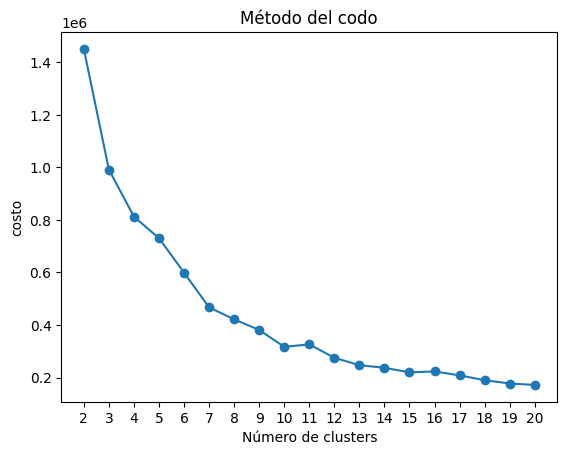

In [51]:
from pyspark.ml.clustering import KMeans
kini = 2; kfin = 20
ks = range(kini, kfin + 1)
costo=[]
DIST = 'euclidean'
for k in range(kini, kfin + 1):
    kmeans= KMeans( featuresCol='FEATURES', k=k, predictionCol='CLUSTER', distanceMeasure = DIST)
    model = kmeans.fit(vdata)
    costo.append(model.summary.trainingCost)
plt.plot(ks, costo, '-o')
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('costo')
plt.xticks(ks)
plt.show()

Elijamos $k = 10$ como numero de centroides

In [52]:
K = 10
km = KMeans(featuresCol='FEATURES', k = K, predictionCol='CLUSTER', distanceMeasure = DIST)
km_model = km.fit(vdata)

Veamos la ubicación de los centroides para cada cluster:

In [53]:
cols_cats

['EDAD_CAT',
 'SEXO_NUM',
 'ESTADO_CIVIL_NUM',
 'MUN_RES_NUM',
 'ESCOLARIDAD_PACIENTE_NUM']

In [54]:
centers = km_model.clusterCenters()
print("Centroides: ")
for center in centers:
  centerR=[round(num, 0) for num in center]
  print(centerR)
print("Variables")
vdata.columns

Centroides: 
[4.0, 0.0, 0.0, 0.0, 1.0]
[4.0, 0.0, 2.0, 51.0, 2.0]
[4.0, 0.0, 1.0, 24.0, 2.0]
[4.0, 0.0, 1.0, 1.0, 6.0]
[4.0, 0.0, 1.0, 154.0, 2.0]
[4.0, 0.0, 1.0, 92.0, 2.0]
[4.0, 0.0, 4.0, 1.0, 1.0]
[4.0, 0.0, 2.0, 4.0, 2.0]
[4.0, 0.0, 1.0, 7.0, 2.0]
[0.0, 1.0, 1.0, 1.0, 2.0]
Variables


['FEATURES']

Ahora realicemos las predicciones aplicando la clusterizacion.

In [55]:
predictions = km_model.transform(vdata)
predictions.distinct().show()

+--------------------+-------+
|            FEATURES|CLUSTER|
+--------------------+-------+
|[4.0,1.0,1.0,4.0,...|      7|
|[4.0,0.0,3.0,8.0,...|      8|
|[4.0,0.0,2.0,7.0,...|      8|
|[2.0,0.0,3.0,5.0,...|      7|
|[3.0,0.0,3.0,101....|      5|
|[4.0,0.0,3.0,8.0,...|      8|
|[5.0,1.0,3.0,6.0,...|      8|
|       (5,[4],[8.0])|      3|
|[5.0,1.0,2.0,48.0...|      1|
|[3.0,1.0,2.0,11.0...|      8|
|[4.0,1.0,2.0,4.0,...|      7|
|[3.0,0.0,1.0,42.0...|      1|
|[4.0,0.0,3.0,6.0,...|      8|
|[5.0,0.0,5.0,52.0...|      1|
|[4.0,1.0,0.0,14.0...|      8|
|[4.0,0.0,3.0,1.0,...|      6|
|[5.0,1.0,4.0,5.0,...|      7|
|[4.0,0.0,5.0,2.0,...|      6|
|[4.0,1.0,0.0,2.0,...|      3|
|[5.0,1.0,3.0,1.0,...|      6|
+--------------------+-------+
only showing top 20 rows



### **3. Evaluar**

Realicemos la evaluación empleando el indice de silueta.

In [56]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator(featuresCol='FEATURES', predictionCol='CLUSTER')
silhouette = evaluator.evaluate(predictions)
print("Índice de la silueta = " + str(silhouette))

Índice de la silueta = 0.5015339351667818


Presente aquí el código desarrollado y el resultado obtenido

##**C) Análisis Predictivo**

Usando el clúster asignado a cada paciente como variable objetivo, cree un modelo predictivo que permita predecir el grupo al que pertenece cada paciente

In [57]:
for center in centers:
  centerR=[round(num, 0) for num in center]
  print(centerR)
print("Variables")

[4.0, 0.0, 0.0, 0.0, 1.0]
[4.0, 0.0, 2.0, 51.0, 2.0]
[4.0, 0.0, 1.0, 24.0, 2.0]
[4.0, 0.0, 1.0, 1.0, 6.0]
[4.0, 0.0, 1.0, 154.0, 2.0]
[4.0, 0.0, 1.0, 92.0, 2.0]
[4.0, 0.0, 4.0, 1.0, 1.0]
[4.0, 0.0, 2.0, 4.0, 2.0]
[4.0, 0.0, 1.0, 7.0, 2.0]
[0.0, 1.0, 1.0, 1.0, 2.0]
Variables


In [58]:
# pobAtendidaDF_cod.show(5)
pobAtendidaDF_cod.show(5)
#pobAtendidaDF.show(5)

+--------+---------+---------------+--------+---------------+---------+----+--------------------+
|ID_UNICO|     SEXO|   ESTADO_CIVIL|ZONA_RES|        MUN_RES|PAIS_NCTO|EDAD|ESCOLARIDAD_PACIENTE|
+--------+---------+---------------+--------+---------------+---------+----+--------------------+
|  676901|MASCULINO|     SOLTERO(A)|  URBANA|  ZONA BANANERA| COLOMBIA|  54|   BASICA SECUNDARIA|
|  676949|MASCULINO|    UNION LIBRE|  URBANA|       MEDELLIN| COLOMBIA|  27|     SIN INFORMACION|
|  676948|MASCULINO|SIN INFORMACION|  URBANA|SIN INFORMACION| COLOMBIA|   0|     SIN INFORMACION|
|  635991| FEMENINO|SIN INFORMACION|  URBANA|         ITAGUI| COLOMBIA|   0|     SIN INFORMACION|
|  676947| FEMENINO|     SOLTERO(A)|  URBANA|         ITAGUI| COLOMBIA|  24|   BASICA SECUNDARIA|
+--------+---------+---------------+--------+---------------+---------+----+--------------------+
only showing top 5 rows



In [59]:
pobAtendidaDF_cod_reduce = pobAtendidaDF_cod.drop('PAIS_NCTO','ZONA_RES')
pobAtendidaDF_cod_reduce.show(5)

+--------+---------+---------------+---------------+----+--------------------+
|ID_UNICO|     SEXO|   ESTADO_CIVIL|        MUN_RES|EDAD|ESCOLARIDAD_PACIENTE|
+--------+---------+---------------+---------------+----+--------------------+
|  676901|MASCULINO|     SOLTERO(A)|  ZONA BANANERA|  54|   BASICA SECUNDARIA|
|  676949|MASCULINO|    UNION LIBRE|       MEDELLIN|  27|     SIN INFORMACION|
|  676948|MASCULINO|SIN INFORMACION|SIN INFORMACION|   0|     SIN INFORMACION|
|  635991| FEMENINO|SIN INFORMACION|         ITAGUI|   0|     SIN INFORMACION|
|  676947| FEMENINO|     SOLTERO(A)|         ITAGUI|  24|   BASICA SECUNDARIA|
+--------+---------+---------------+---------------+----+--------------------+
only showing top 5 rows



In [60]:
pobAtendidaNum_cod = pobAtendidaDF_cod_reduce
pobAtendidaNum_cod.show(5)

+--------+---------+---------------+---------------+----+--------------------+
|ID_UNICO|     SEXO|   ESTADO_CIVIL|        MUN_RES|EDAD|ESCOLARIDAD_PACIENTE|
+--------+---------+---------------+---------------+----+--------------------+
|  676901|MASCULINO|     SOLTERO(A)|  ZONA BANANERA|  54|   BASICA SECUNDARIA|
|  676949|MASCULINO|    UNION LIBRE|       MEDELLIN|  27|     SIN INFORMACION|
|  676948|MASCULINO|SIN INFORMACION|SIN INFORMACION|   0|     SIN INFORMACION|
|  635991| FEMENINO|SIN INFORMACION|         ITAGUI|   0|     SIN INFORMACION|
|  676947| FEMENINO|     SOLTERO(A)|         ITAGUI|  24|   BASICA SECUNDARIA|
+--------+---------+---------------+---------------+----+--------------------+
only showing top 5 rows



In [61]:
pobAtendidaNum_cod.columns

['ID_UNICO', 'SEXO', 'ESTADO_CIVIL', 'MUN_RES', 'EDAD', 'ESCOLARIDAD_PACIENTE']

In [62]:
for c in pobAtendidaNum_cod.columns[1:]:
  if c != 'EDAD':
    # Columna
    indexer = StringIndexer(inputCol = c, outputCol = c + '_NUM')
    # Asignacion de valores de indices los strings
    indexer = indexer.fit(pobAtendidaNum_cod)
    # Creacion de columna con valores de indices
    pobAtendidaNum_cod = indexer.transform(pobAtendidaNum_cod)

In [63]:
pobAtendidaNum_cod.show(5)

+--------+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+
|ID_UNICO|     SEXO|   ESTADO_CIVIL|        MUN_RES|EDAD|ESCOLARIDAD_PACIENTE|SEXO_NUM|ESTADO_CIVIL_NUM|MUN_RES_NUM|ESCOLARIDAD_PACIENTE_NUM|
+--------+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+
|  676901|MASCULINO|     SOLTERO(A)|  ZONA BANANERA|  54|   BASICA SECUNDARIA|     1.0|             0.0|       14.0|                     0.0|
|  676949|MASCULINO|    UNION LIBRE|       MEDELLIN|  27|     SIN INFORMACION|     1.0|             3.0|        1.0|                     2.0|
|  676948|MASCULINO|SIN INFORMACION|SIN INFORMACION|   0|     SIN INFORMACION|     1.0|             2.0|        3.0|                     2.0|
|  635991| FEMENINO|SIN INFORMACION|         ITAGUI|   0|     SIN INFORMACION|     0.0|             2.0|        2.0|                     2.0|
|  676

In [64]:
pobAtendidaNum_cod.count()

55962

In [65]:
pobAtendidaNum_cod = pobAtendidaNum_cod.withColumn("EDAD_CAT", categorize_udf(F.col("EDAD")))
pobAtendidaNum_cod.show(5)

+--------+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+--------+
|ID_UNICO|     SEXO|   ESTADO_CIVIL|        MUN_RES|EDAD|ESCOLARIDAD_PACIENTE|SEXO_NUM|ESTADO_CIVIL_NUM|MUN_RES_NUM|ESCOLARIDAD_PACIENTE_NUM|EDAD_CAT|
+--------+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+--------+
|  676901|MASCULINO|     SOLTERO(A)|  ZONA BANANERA|  54|   BASICA SECUNDARIA|     1.0|             0.0|       14.0|                     0.0|       4|
|  676949|MASCULINO|    UNION LIBRE|       MEDELLIN|  27|     SIN INFORMACION|     1.0|             3.0|        1.0|                     2.0|       4|
|  676948|MASCULINO|SIN INFORMACION|SIN INFORMACION|   0|     SIN INFORMACION|     1.0|             2.0|        3.0|                     2.0|       0|
|  635991| FEMENINO|SIN INFORMACION|         ITAGUI|   0|     SIN INFORMACION|     0.0|       

In [66]:
cols_cats

['EDAD_CAT',
 'SEXO_NUM',
 'ESTADO_CIVIL_NUM',
 'MUN_RES_NUM',
 'ESCOLARIDAD_PACIENTE_NUM']

In [67]:
vector_col = "FEATURES"
assembler = VectorAssembler(inputCols = cols_cats, outputCol = vector_col)
# Inspeccion del resultado
vector_features = assembler.transform(pobAtendidaNum_cod)

In [68]:
vector_features.show(5)

+--------+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+--------+--------------------+
|ID_UNICO|     SEXO|   ESTADO_CIVIL|        MUN_RES|EDAD|ESCOLARIDAD_PACIENTE|SEXO_NUM|ESTADO_CIVIL_NUM|MUN_RES_NUM|ESCOLARIDAD_PACIENTE_NUM|EDAD_CAT|            FEATURES|
+--------+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+--------+--------------------+
|  676901|MASCULINO|     SOLTERO(A)|  ZONA BANANERA|  54|   BASICA SECUNDARIA|     1.0|             0.0|       14.0|                     0.0|       4|[4.0,1.0,0.0,14.0...|
|  676949|MASCULINO|    UNION LIBRE|       MEDELLIN|  27|     SIN INFORMACION|     1.0|             3.0|        1.0|                     2.0|       4|[4.0,1.0,3.0,1.0,...|
|  676948|MASCULINO|SIN INFORMACION|SIN INFORMACION|   0|     SIN INFORMACION|     1.0|             2.0|        3.0|                     2.0

In [69]:
vector_features.count()

55962

Vector caracteristico

In [70]:
vdata_id = vector_features.select("ID_UNICO","FEATURES")
vdata_id.show()

+--------+--------------------+
|ID_UNICO|            FEATURES|
+--------+--------------------+
|  676901|[4.0,1.0,0.0,14.0...|
|  676949|[4.0,1.0,3.0,1.0,...|
|  676948|[0.0,1.0,2.0,3.0,...|
|  635991|[0.0,0.0,2.0,2.0,...|
|  676947| (5,[0,3],[3.0,2.0])|
|  676946|[0.0,1.0,2.0,2.0,...|
|  666994|[4.0,1.0,3.0,0.0,...|
|  676812|[4.0,1.0,0.0,1.0,...|
|  676945|[0.0,1.0,2.0,0.0,...|
|  676944|[4.0,1.0,0.0,1.0,...|
|  676943|[4.0,0.0,2.0,3.0,...|
|  676942|[4.0,0.0,2.0,3.0,...|
|  656425|[4.0,1.0,0.0,81.0...|
|  676941|[4.0,0.0,2.0,0.0,...|
|  673748|[4.0,0.0,3.0,6.0,...|
|  624331|[5.0,1.0,1.0,0.0,...|
|  676940|[3.0,0.0,2.0,3.0,...|
|  676939|[4.0,1.0,3.0,0.0,...|
|  676937| (5,[0,2],[4.0,3.0])|
|  676938|       (5,[0],[2.0])|
+--------+--------------------+
only showing top 20 rows



In [71]:
predictions = km_model.transform(vdata_id.select("FEATURES"))
predictions.distinct().show()

+--------------------+-------+
|            FEATURES|CLUSTER|
+--------------------+-------+
|[4.0,1.0,1.0,4.0,...|      7|
|[4.0,0.0,3.0,8.0,...|      8|
|[4.0,0.0,2.0,7.0,...|      8|
|[2.0,0.0,3.0,5.0,...|      7|
|[3.0,0.0,3.0,101....|      5|
|[4.0,0.0,3.0,8.0,...|      8|
|[5.0,1.0,3.0,6.0,...|      8|
|       (5,[4],[8.0])|      3|
|[5.0,1.0,2.0,48.0...|      1|
|[3.0,1.0,2.0,11.0...|      8|
|[4.0,1.0,2.0,4.0,...|      7|
|[3.0,0.0,1.0,42.0...|      1|
|[4.0,0.0,3.0,6.0,...|      8|
|[5.0,0.0,5.0,52.0...|      1|
|[4.0,1.0,0.0,14.0...|      8|
|[4.0,0.0,3.0,1.0,...|      6|
|[5.0,1.0,4.0,5.0,...|      7|
|[4.0,0.0,5.0,2.0,...|      6|
|[4.0,1.0,0.0,2.0,...|      3|
|[5.0,1.0,3.0,1.0,...|      6|
+--------------------+-------+
only showing top 20 rows



In [72]:
predictions.count()

55962

In [73]:
# Agregar índices artificiales
vdata_id = vdata_id.withColumn("index", F.monotonically_increasing_id())
# vdata_id.show(5)
predictions = predictions.select("CLUSTER").withColumn("index", F.monotonically_increasing_id())
# predictions.show(5)
df_predictions = vdata_id.join(predictions, on="index", how="inner").drop("index","FEATURES")
df_predictions.show(5)

+--------+-------+
|ID_UNICO|CLUSTER|
+--------+-------+
|  676901|      8|
|  676949|      6|
|  676948|      9|
|  635991|      9|
|  676947|      0|
+--------+-------+
only showing top 5 rows



In [74]:
pobAtendidaNum_cod = pobAtendidaNum_cod.join(df_predictions, on="ID_UNICO", how="inner")

In [75]:
pobAtendidaNum_cod.show(5)

+--------+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+--------+-------+
|ID_UNICO|     SEXO|   ESTADO_CIVIL|        MUN_RES|EDAD|ESCOLARIDAD_PACIENTE|SEXO_NUM|ESTADO_CIVIL_NUM|MUN_RES_NUM|ESCOLARIDAD_PACIENTE_NUM|EDAD_CAT|CLUSTER|
+--------+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+--------+-------+
|  676901|MASCULINO|     SOLTERO(A)|  ZONA BANANERA|  54|   BASICA SECUNDARIA|     1.0|             0.0|       14.0|                     0.0|       4|      8|
|  676949|MASCULINO|    UNION LIBRE|       MEDELLIN|  27|     SIN INFORMACION|     1.0|             3.0|        1.0|                     2.0|       4|      6|
|  676948|MASCULINO|SIN INFORMACION|SIN INFORMACION|   0|     SIN INFORMACION|     1.0|             2.0|        3.0|                     2.0|       0|      9|
|  635991| FEMENINO|SIN INFORMACION|         I

In [76]:
pobAtendidaNum_cod.count()

55962

### **Preparación**


In [77]:
pobAtendidaNum_cod.cache()

DataFrame[ID_UNICO: int, SEXO: string, ESTADO_CIVIL: string, MUN_RES: string, EDAD: int, ESCOLARIDAD_PACIENTE: string, SEXO_NUM: double, ESTADO_CIVIL_NUM: double, MUN_RES_NUM: double, ESCOLARIDAD_PACIENTE_NUM: double, EDAD_CAT: int, CLUSTER: int]

In [78]:
# Datos
pobAtendidaNum_cod.show(5)

+--------+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+--------+-------+
|ID_UNICO|     SEXO|   ESTADO_CIVIL|        MUN_RES|EDAD|ESCOLARIDAD_PACIENTE|SEXO_NUM|ESTADO_CIVIL_NUM|MUN_RES_NUM|ESCOLARIDAD_PACIENTE_NUM|EDAD_CAT|CLUSTER|
+--------+---------+---------------+---------------+----+--------------------+--------+----------------+-----------+------------------------+--------+-------+
|  676901|MASCULINO|     SOLTERO(A)|  ZONA BANANERA|  54|   BASICA SECUNDARIA|     1.0|             0.0|       14.0|                     0.0|       4|      8|
|  676949|MASCULINO|    UNION LIBRE|       MEDELLIN|  27|     SIN INFORMACION|     1.0|             3.0|        1.0|                     2.0|       4|      6|
|  676948|MASCULINO|SIN INFORMACION|SIN INFORMACION|   0|     SIN INFORMACION|     1.0|             2.0|        3.0|                     2.0|       0|      9|
|  635991| FEMENINO|SIN INFORMACION|         I

Inspección de las salidas categoricas

In [79]:
pobAtendidaNum_cod.groupBy('CLUSTER').count().show()

+-------+-----+
|CLUSTER|count|
+-------+-----+
|      1|  174|
|      6| 9340|
|      3| 9968|
|      5|   87|
|      9| 5473|
|      4|   63|
|      8| 2942|
|      7| 5982|
|      2|  368|
|      0|21565|
+-------+-----+



Como los datos estan desbalanceados vamos a usar la biblioteca `imbalanced-learn` para realizar la generación sintética

In [80]:
model_cols = cols_cats + ['CLUSTER']
model_cols

['EDAD_CAT',
 'SEXO_NUM',
 'ESTADO_CIVIL_NUM',
 'MUN_RES_NUM',
 'ESCOLARIDAD_PACIENTE_NUM',
 'CLUSTER']

In [81]:
from imblearn.over_sampling import SMOTE

In [82]:
# Se separan los labels de las features

# Selecciona las columnas de características y la etiqueta
pandas_df = pobAtendidaNum_cod.select(*model_cols).toPandas()
print(type(pandas_df))
X = pandas_df.drop(columns=["CLUSTER"])
y = pandas_df["CLUSTER"]

<class 'pandas.core.frame.DataFrame'>


In [83]:
X.columns

Index(['EDAD_CAT', 'SEXO_NUM', 'ESTADO_CIVIL_NUM', 'MUN_RES_NUM',
       'ESCOLARIDAD_PACIENTE_NUM'],
      dtype='object')

In [84]:
y

,CLUSTER
0,8
1,6
2,9
3,9
4,0
...,...
55957,0
55958,0
55959,0
55960,0


In [85]:
# Se aplica SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [86]:
# Crea un nuevo DataFrame con los datos balanceados
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df["CLUSTER"] = y_resampled

In [87]:
resampled_df.head()

,EDAD_CAT,SEXO_NUM,ESTADO_CIVIL_NUM,MUN_RES_NUM,ESCOLARIDAD_PACIENTE_NUM,CLUSTER
0,4,1.0,0.0,14.0,0.0,8
1,4,1.0,3.0,1.0,2.0,6
2,0,1.0,2.0,3.0,2.0,9
3,0,0.0,2.0,2.0,2.0,9
4,3,0.0,0.0,2.0,0.0,0


In [88]:
resampled_df.dtypes

,0
EDAD_CAT,int32
SEXO_NUM,float64
ESTADO_CIVIL_NUM,float64
MUN_RES_NUM,float64
ESCOLARIDAD_PACIENTE_NUM,float64
CLUSTER,int32


In [89]:
print(type(resampled_df))

<class 'pandas.core.frame.DataFrame'>


In [90]:
# Reintegrar los Datos a PySpark

# Convertir a lista de diccionarios
rows = resampled_df.to_dict(orient="records")
# Crear DataFrame de PySpark
pobAtendidaNum_cod_balanced = spark.createDataFrame(rows)
pobAtendidaNum_cod_balanced.show(5)

/content/spark-3.0.1-bin-hadoop3.2/python/pyspark/sql/session.py:381: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


+-------+--------+------------------------+----------------+-----------+--------+
|CLUSTER|EDAD_CAT|ESCOLARIDAD_PACIENTE_NUM|ESTADO_CIVIL_NUM|MUN_RES_NUM|SEXO_NUM|
+-------+--------+------------------------+----------------+-----------+--------+
|      8|       4|                     0.0|             0.0|       14.0|     1.0|
|      6|       4|                     2.0|             3.0|        1.0|     1.0|
|      9|       0|                     2.0|             2.0|        3.0|     1.0|
|      9|       0|                     2.0|             2.0|        2.0|     0.0|
|      0|       3|                     0.0|             0.0|        2.0|     0.0|
+-------+--------+------------------------+----------------+-----------+--------+
only showing top 5 rows



In [91]:
pobAtendidaNum_cod_balanced.printSchema()

root
 |-- CLUSTER: long (nullable = true)
 |-- EDAD_CAT: long (nullable = true)
 |-- ESCOLARIDAD_PACIENTE_NUM: double (nullable = true)
 |-- ESTADO_CIVIL_NUM: double (nullable = true)
 |-- MUN_RES_NUM: double (nullable = true)
 |-- SEXO_NUM: double (nullable = true)



In [92]:
pobAtendidaNum_cod_balanced.groupBy('CLUSTER').count().show()

+-------+-----+
|CLUSTER|count|
+-------+-----+
|      0|21565|
|      7|21565|
|      6|21565|
|      9|21565|
|      5|21565|
|      1|21565|
|      3|21565|
|      8|21565|
|      2|21565|
|      4|21565|
+-------+-----+



Eliminación de las variables y creacion del vector de caracteristicas

In [93]:
cols_cats

['EDAD_CAT',
 'SEXO_NUM',
 'ESTADO_CIVIL_NUM',
 'MUN_RES_NUM',
 'ESCOLARIDAD_PACIENTE_NUM']

In [94]:
model_features = cols_cats
vectorAssembler = VectorAssembler(inputCols = model_features, outputCol = 'FEATURES')
vdata = vectorAssembler.transform(pobAtendidaNum_cod_balanced)

In [95]:
vdata = vdata.select(['FEATURES', 'CLUSTER'])
vdata.show(5, truncate = False, vertical = True)

-RECORD 0--------------------------
 FEATURES | [4.0,1.0,0.0,14.0,0.0] 
 CLUSTER  | 8                      
-RECORD 1--------------------------
 FEATURES | [4.0,1.0,3.0,1.0,2.0]  
 CLUSTER  | 6                      
-RECORD 2--------------------------
 FEATURES | [0.0,1.0,2.0,3.0,2.0]  
 CLUSTER  | 9                      
-RECORD 3--------------------------
 FEATURES | [0.0,0.0,2.0,2.0,2.0]  
 CLUSTER  | 9                      
-RECORD 4--------------------------
 FEATURES | (5,[0,3],[3.0,2.0])    
 CLUSTER  | 0                      
only showing top 5 rows



Creamos los conjuntos de datos de entrenamiento y evaluación (Split)

In [96]:
(trainingData, testData) = vdata.randomSplit([0.7, 0.3])
print(trainingData.count())
print(testData.count())
print("---------------------")
print(vdata.count())

150901
64749
---------------------
215650


### **Selección del modelo**

In [97]:
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

#### **Árboles de decisión para clasificación**


In [98]:
from pyspark.ml.classification import DecisionTreeClassifier

In [99]:
dt = DecisionTreeClassifier(labelCol="CLUSTER", featuresCol="FEATURES", maxBins = 200)
dt_model=dt.fit(trainingData)

In [100]:
predict_train = dt_model.transform(trainingData)
predict_train.select('CLUSTER','prediction').show(5)

+-------+----------+
|CLUSTER|prediction|
+-------+----------+
|      9|       9.0|
|      9|       9.0|
|      9|       9.0|
|      9|       9.0|
|      9|       9.0|
+-------+----------+
only showing top 5 rows



### **Evaluar**

#### **Arboles de decisión**

In [101]:
predict_test = dt_model.transform(testData)
predict_test.select('CLUSTER','prediction').show(5)

+-------+----------+
|CLUSTER|prediction|
+-------+----------+
|      9|       9.0|
|      9|       9.0|
|      9|       9.0|
|      9|       9.0|
|      9|       9.0|
+-------+----------+
only showing top 5 rows



In [102]:
clase_real = predict_test.select(['CLUSTER']).collect()
clase_prediccion = predict_test.select(['prediction']).collect()
print("Medidas de error")
print(classification_report(clase_real, clase_prediccion))

Medidas de error
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6458
           1       0.97      1.00      0.99      6536
           2       1.00      0.99      0.99      6472
           3       0.97      1.00      0.98      6384
           4       1.00      0.99      1.00      6442
           5       0.99      0.99      0.99      6504
           6       0.49      0.97      0.65      6491
           7       0.99      0.87      0.93      6611
           8       1.00      1.00      1.00      6393
           9       0.88      1.00      0.94      6458

    accuracy                           0.88     64749
   macro avg       0.83      0.88      0.85     64749
weighted avg       0.83      0.88      0.85     64749



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [103]:
print("Matriz de confusión")
print(confusion_matrix(clase_real, clase_prediccion))
evaluator = MulticlassClassificationEvaluator(labelCol='CLUSTER')

Matriz de confusión
[[   0    0    0    0    0    0 6031    0    0  427]
 [   0 6536    0    0    0    0    0    0    0    0]
 [   0   86 6386    0    0    0    0    0    0    0]
 [   0    0    0 6364    0    0    0   17    3    0]
 [   0    0    0    0 6403   39    0    0    0    0]
 [   0   82    0    0    9 6413    0    0    0    0]
 [   0    0    0  153    0    0 6275   15    0   48]
 [   0    0    0   24    0    0  437 5766    1  383]
 [   0    0    0    0    0    0    0    0 6393    0]
 [   0    0    0    0    0    0    0    0    0 6458]]


In [104]:
print('Área ROC con los datos de evaluación', evaluator.evaluate(predict_test))

Área ROC con los datos de evaluación 0.8471322692450518


##**D) Validación**

Cree un archivo con la información de un nuevo paciente por cada integrante del grupo y utilice el modelo de predicción creado anteriormente para predecir el clúster al que pertenecerían los nuevos pacientes

A continuación se muestran los registros con los que vamos a trabajar:

| ID_UNICO | SEXO      | ESTADO_CIVIL | ZONA_RES | MUN_RES    | PAIS_NCTO | EDAD | ESCOLARIDAD_PACIENTE |
|----------|-----------|--------------|----------|------------|-----------|------|----------------------|
| 000001   | MASCULINO | CASADO(A)    | URBANA   | MEDELLIN   | COLOMBIA  | 53   | ESPECIALIZACION      |
| 000002   | MASCULINO | SOLTERO(A)   | URBANA   | SANTUARIO  | COLOMBIA  | 40   | PROFESIONAL          |


In [105]:
pobAtendidaDF_cod.show(5)

+--------+---------+---------------+--------+---------------+---------+----+--------------------+
|ID_UNICO|     SEXO|   ESTADO_CIVIL|ZONA_RES|        MUN_RES|PAIS_NCTO|EDAD|ESCOLARIDAD_PACIENTE|
+--------+---------+---------------+--------+---------------+---------+----+--------------------+
|  676901|MASCULINO|     SOLTERO(A)|  URBANA|  ZONA BANANERA| COLOMBIA|  54|   BASICA SECUNDARIA|
|  676949|MASCULINO|    UNION LIBRE|  URBANA|       MEDELLIN| COLOMBIA|  27|     SIN INFORMACION|
|  676948|MASCULINO|SIN INFORMACION|  URBANA|SIN INFORMACION| COLOMBIA|   0|     SIN INFORMACION|
|  635991| FEMENINO|SIN INFORMACION|  URBANA|         ITAGUI| COLOMBIA|   0|     SIN INFORMACION|
|  676947| FEMENINO|     SOLTERO(A)|  URBANA|         ITAGUI| COLOMBIA|  24|   BASICA SECUNDARIA|
+--------+---------+---------------+--------+---------------+---------+----+--------------------+
only showing top 5 rows



In [106]:
pobAtendidaDF_cod.count()

55962

In [107]:
# Datos
new_data = [
    ("000001", "MASCULINO", "CASADO(A)", "URBANA", "MEDELLIN", "COLOMBIA", 53, "ESPECIALIZACION"),
    ("000002", "MASCULINO", "SOLTERO(A)", "URBANA", "SANTUARIO", "COLOMBIA", 40, "PROFESIONAL"),
]

# Definir el esquema
schema = StructType([
    StructField("ID_UNICO", StringType(), True),
    StructField("SEXO", StringType(), True),
    StructField("ESTADO_CIVIL", StringType(), True),
    StructField("ZONA_RES", StringType(), True),
    StructField("MUN_RES", StringType(), True),
    StructField("PAIS_NCTO", StringType(), True),
    StructField("EDAD", IntegerType(), True),
    StructField("ESCOLARIDAD_PACIENTE", StringType(), True)
])

new_patients_df = spark.createDataFrame(data=new_data, schema = schema)
new_patients_df.show()

+--------+---------+------------+--------+---------+---------+----+--------------------+
|ID_UNICO|     SEXO|ESTADO_CIVIL|ZONA_RES|  MUN_RES|PAIS_NCTO|EDAD|ESCOLARIDAD_PACIENTE|
+--------+---------+------------+--------+---------+---------+----+--------------------+
|  000001|MASCULINO|   CASADO(A)|  URBANA| MEDELLIN| COLOMBIA|  53|     ESPECIALIZACION|
|  000002|MASCULINO|  SOLTERO(A)|  URBANA|SANTUARIO| COLOMBIA|  40|         PROFESIONAL|
+--------+---------+------------+--------+---------+---------+----+--------------------+



In [108]:
# Agregar el nuevo registro
df_updated = pobAtendidaDF_cod.union(new_patients_df)

# Mostrar el DataFrame actualizado
df_updated.count()

55964

In [109]:
df_updated.tail(5)

[Row(ID_UNICO='249215', SEXO='MASCULINO', ESTADO_CIVIL='SOLTERO(A)', ZONA_RES='URBANA', MUN_RES='ENVIGADO', PAIS_NCTO='COLOMBIA', EDAD=30, ESCOLARIDAD_PACIENTE='BASICA SECUNDARIA'),
 Row(ID_UNICO='249209', SEXO='MASCULINO', ESTADO_CIVIL='SOLTERO(A)', ZONA_RES='URBANA', MUN_RES='ENVIGADO', PAIS_NCTO='COLOMBIA', EDAD=29, ESCOLARIDAD_PACIENTE='MEDIA ACADEMICA O CLASICA'),
 Row(ID_UNICO='249200', SEXO='MASCULINO', ESTADO_CIVIL='CASADO(A)', ZONA_RES='URBANA', MUN_RES='CERETE', PAIS_NCTO='COLOMBIA', EDAD=48, ESCOLARIDAD_PACIENTE='SIN INFORMACION'),
 Row(ID_UNICO='000001', SEXO='MASCULINO', ESTADO_CIVIL='CASADO(A)', ZONA_RES='URBANA', MUN_RES='MEDELLIN', PAIS_NCTO='COLOMBIA', EDAD=53, ESCOLARIDAD_PACIENTE='ESPECIALIZACION'),
 Row(ID_UNICO='000002', SEXO='MASCULINO', ESTADO_CIVIL='SOLTERO(A)', ZONA_RES='URBANA', MUN_RES='SANTUARIO', PAIS_NCTO='COLOMBIA', EDAD=40, ESCOLARIDAD_PACIENTE='PROFESIONAL')]

In [110]:
df_updated_num = df_updated

for c in df_updated_num.columns[1:]:
  if c != 'EDAD':
    # Columna
    indexer = StringIndexer(inputCol = c, outputCol = c + '_NUM')
    # Asignacion de valores de indices los strings
    indexer = indexer.fit(df_updated_num)
    # Creacion de columna con valores de indices
    df_updated_num = indexer.transform(df_updated_num)

In [111]:
df_updated_num.tail(5)

[Row(ID_UNICO='249215', SEXO='MASCULINO', ESTADO_CIVIL='SOLTERO(A)', ZONA_RES='URBANA', MUN_RES='ENVIGADO', PAIS_NCTO='COLOMBIA', EDAD=30, ESCOLARIDAD_PACIENTE='BASICA SECUNDARIA', SEXO_NUM=1.0, ESTADO_CIVIL_NUM=0.0, ZONA_RES_NUM=0.0, MUN_RES_NUM=0.0, PAIS_NCTO_NUM=0.0, ESCOLARIDAD_PACIENTE_NUM=0.0),
 Row(ID_UNICO='249209', SEXO='MASCULINO', ESTADO_CIVIL='SOLTERO(A)', ZONA_RES='URBANA', MUN_RES='ENVIGADO', PAIS_NCTO='COLOMBIA', EDAD=29, ESCOLARIDAD_PACIENTE='MEDIA ACADEMICA O CLASICA', SEXO_NUM=1.0, ESTADO_CIVIL_NUM=0.0, ZONA_RES_NUM=0.0, MUN_RES_NUM=0.0, PAIS_NCTO_NUM=0.0, ESCOLARIDAD_PACIENTE_NUM=3.0),
 Row(ID_UNICO='249200', SEXO='MASCULINO', ESTADO_CIVIL='CASADO(A)', ZONA_RES='URBANA', MUN_RES='CERETE', PAIS_NCTO='COLOMBIA', EDAD=48, ESCOLARIDAD_PACIENTE='SIN INFORMACION', SEXO_NUM=1.0, ESTADO_CIVIL_NUM=1.0, ZONA_RES_NUM=0.0, MUN_RES_NUM=120.0, PAIS_NCTO_NUM=0.0, ESCOLARIDAD_PACIENTE_NUM=2.0),
 Row(ID_UNICO='000001', SEXO='MASCULINO', ESTADO_CIVIL='CASADO(A)', ZONA_RES='URBANA', MU

In [112]:
df_updated_num = df_updated_num.withColumn("EDAD_CAT", categorize_udf(F.col("EDAD")))
df_updated_num.show(3)

+--------+---------+---------------+--------+---------------+---------+----+--------------------+--------+----------------+------------+-----------+-------------+------------------------+--------+
|ID_UNICO|     SEXO|   ESTADO_CIVIL|ZONA_RES|        MUN_RES|PAIS_NCTO|EDAD|ESCOLARIDAD_PACIENTE|SEXO_NUM|ESTADO_CIVIL_NUM|ZONA_RES_NUM|MUN_RES_NUM|PAIS_NCTO_NUM|ESCOLARIDAD_PACIENTE_NUM|EDAD_CAT|
+--------+---------+---------------+--------+---------------+---------+----+--------------------+--------+----------------+------------+-----------+-------------+------------------------+--------+
|  676901|MASCULINO|     SOLTERO(A)|  URBANA|  ZONA BANANERA| COLOMBIA|  54|   BASICA SECUNDARIA|     1.0|             0.0|         0.0|       14.0|          0.0|                     0.0|       4|
|  676949|MASCULINO|    UNION LIBRE|  URBANA|       MEDELLIN| COLOMBIA|  27|     SIN INFORMACION|     1.0|             3.0|         0.0|        1.0|          0.0|                     2.0|       4|
|  676948|MASCU

In [113]:
vector_col = "FEATURES"
assembler = VectorAssembler(inputCols = cols_cats, outputCol = vector_col)
# Inspeccion del resultado
vector_features = assembler.transform(df_updated_num)

In [114]:
vada_val = vector_features.select("ID_UNICO","FEATURES")
vada_val.tail(5)

[Row(ID_UNICO='249215', FEATURES=SparseVector(5, {0: 4.0, 1: 1.0})),
 Row(ID_UNICO='249209', FEATURES=DenseVector([4.0, 1.0, 0.0, 0.0, 3.0])),
 Row(ID_UNICO='249200', FEATURES=DenseVector([4.0, 1.0, 1.0, 120.0, 2.0])),
 Row(ID_UNICO='000001', FEATURES=DenseVector([4.0, 1.0, 1.0, 1.0, 7.0])),
 Row(ID_UNICO='000002', FEATURES=DenseVector([4.0, 1.0, 0.0, 100.0, 4.0]))]

In [115]:
val_test = vada_val.where(vada_val.ID_UNICO.isin(["000001", "000002"]))
val_test.show()

+--------+--------------------+
|ID_UNICO|            FEATURES|
+--------+--------------------+
|  000001|[4.0,1.0,1.0,1.0,...|
|  000002|[4.0,1.0,0.0,100....|
+--------+--------------------+



In [116]:
predict_test = dt_model.transform(val_test)
predict_test.show(truncate = False)

+--------+-----------------------+-----------------------------------------------+------------------------------------------------------------------------+----------+
|ID_UNICO|FEATURES               |rawPrediction                                  |probability                                                             |prediction|
+--------+-----------------------+-----------------------------------------------+------------------------------------------------------------------------+----------+
|000001  |[4.0,1.0,1.0,1.0,7.0]  |[0.0,0.0,0.0,14471.0,0.0,0.0,369.0,0.0,0.0,0.0]|[0.0,0.0,0.0,0.9751347708894879,0.0,0.0,0.02486522911051213,0.0,0.0,0.0]|3.0       |
|000002  |[4.0,1.0,0.0,100.0,4.0]|[0.0,0.0,0.0,0.0,0.0,14720.0,0.0,0.0,0.0,0.0]  |[0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0]                               |5.0       |
+--------+-----------------------+-----------------------------------------------+------------------------------------------------------------------------+----------

```
Centroides:

[4.0, 0.0, 0.0, 0.0, 1.0]
[4.0, 0.0, 2.0, 51.0, 2.0]
[4.0, 0.0, 1.0, 24.0, 2.0]
[4.0, 0.0, 1.0, 1.0, 6.0]
[4.0, 0.0, 1.0, 154.0, 2.0]
[4.0, 0.0, 1.0, 92.0, 2.0]
[4.0, 0.0, 4.0, 1.0, 1.0]
[4.0, 0.0, 2.0, 4.0, 2.0]
[4.0, 0.0, 1.0, 7.0, 2.0]
[0.0, 1.0, 1.0, 1.0, 2.0]

Estructura:

['EDAD_CAT',
 'SEXO_NUM',
 'ESTADO_CIVIL_NUM',
 'MUN_RES_NUM',
 'ESCOLARIDAD_PACIENTE_NUM']

```

##**Análisis de los resultados**

Analice la calidad de los modelos obtenidos y presente sus conclusiones sobre el ejercicio.

1. El indice de la silueta = 0.5015339351667818 indica que la cantidad de cluster escogida, 10 según la gráfica de codo, es adecuada para la caracterización de los usuarios.

2. Se usó un árbol de clasificación como modelo de aprendizaje ya que este es aconcejable según el tipo de datos suministrados.

2. Tanto la curva ROC como la matriz de confusión indican que el modelo usado es adecuado para una correcta clasificación de  los usuarios.

3. Los datos de validación usados fueron clasificados adecuadamente por el modelo, lo que valida la conclusión 2. Según los datos suministrados el  usuario con ID: 000001 pertenece al cluster 3 y fue clasificado, según el modelo, en dicho cluster. De igual forma con el usuario con ID: 000002, que debía estar en el cluster 5 y efectivamente fue clasificado ahí.

4. Para mantener el esquema de los datos los de validación se agregaron al final de tabla original y se realizó todo el prepocesamiento y luego se seleccionaron estos 2 datos de la tabla. De acuerdo con la conclusión 3 estos fueron clasificados adecuadamente. No obstante, se entiende que el procedimiento realizado no es óptimo por el tiempo de ejecución y el consumo de recuros, por lo tanto se deja como trabajo posterior mejorar esta parte del algoritmo.

5. Si bien puedo haberse usado una clusterización mayor, con 12 o 14 cluster, las pruebas realizadas indicaban que el modelo no tenía una mejoría notable por lo tanto, apoyados en la gráfica de codo, de opto por que fueran 10.

6. Como se indicó previamente se dio tratamiento de outliers a la zona de residencia y al país ya que tanto la zona urbana como el país Colombia son altamente predominantes en los datos.

7. En este análisis nos basamos en los rangos de edad indicados y en función de estos se trabajó el tratamiento de los datos y la clasificación de los cluster pero también puede realizarse esta en función de la escolaridad o el municipio de residencia, trabajo que se deja para futuras oportunidades.

8. También se hizo bastante notorio, en las pruebas realizadas, que cada vez que se corre el modelo se cambia la clusterización y por tanto los resultados optenidos, aunque en todos los casos de las pruebas realizadas estos fueron superiores al 0.8 en la curva ROC.



## **Referencias**

1. https://dcain.etsin.upm.es/~carlos/bookAA/03.1_Clustering-K-Means.html
2. https://qu4nt.github.io/sklearn-doc-es/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
3. https://forum.huawei.com/enterprise/es/%C2%BFc%C3%B3mo-introducirse-en-el-camino-de-la-ciencia-de-datos/thread/667237354135502848-667212895009779712
4. https://dcain.etsin.upm.es/~carlos/bookAA/03.1_Clustering-K-Means.html
5. https://learn.microsoft.com/en-us/azure/synapse-analytics/spark/apache-spark-machine-learning-mllib-notebook